In [1]:
import moth
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy
import scipy.signal
import h5py

PATH = '/storage/home/adz6/group/project'
VNADATAPATH = os.path.join(PATH, 'datasets/data/lab/vna')
DAQDATAPATH = os.path.join(PATH, 'datasets/data/lab/dig')

VNARESULTS = os.path.join(PATH, 'results/moth/vna')

LABDATAPATH = os.path.join(PATH, 'labdata')
#MOTHPATH = os.path.join(PATH, 'moth')
#MOTHDATA = os.path.join(MOTHPATH, 'data/datasets')
#PLOTPATH = os.path.join(PATH, 'plots/moth')
#MOTHRESULTS = os.path.join(PATH, 'results/moth')


def CalculateMagPhase(h5data, name, nch=120):
    
    new_h5file = h5py.File(name, 'w')
    
    for i, key_i in enumerate(h5data):
        new_h5file.create_group(key_i)
        print(key_i)
        for j, key_j in enumerate(h5data[key_i]):
            if key_j == 'array':
                phase = np.unwrap(np.angle(h5data[key_i][key_j][:, 0:nch, :]), axis=1)
                mag = abs(datafile[key_i][key_j][:, 0:nch, :])
                new_h5file[key_i].create_dataset('phase', data = phase)
                new_h5file[key_i].create_dataset('mag', data = mag)
            elif key_j == 'freq':
                new_h5file[key_i].create_dataset(key_j, data = h5data[key_i][key_j][:])
                
    
    new_h5file.close()
    
    
def SpatialPhaseCorrection(rad, init_phase):
    
    array_rad = 0.10
    rotation_angles = np.arange(0, 360, 3)
    initial_phase = - np.radians(init_phase)
    frequency = 25.8e9
    c = 3e8
    wavelength = c / frequency

    x = rad 
    y = 0

    x_array = array_rad * np.cos(np.radians(rotation_angles) + initial_phase)
    y_array = array_rad * np.sin(np.radians(rotation_angles) + initial_phase)
    d = np.sqrt((x - x_array) ** 2 + (y - y_array) ** 2)

    phase = 2 * np.pi * d / wavelength

    return phase - phase[0]

    
    
        


    

In [2]:
os.listdir(VNADATAPATH)

['211206_cres2_vna_trace.h5',
 '211214_cres2_vna_trace_10slot.h5',
 '211220_cres2_vna_trace.h5',
 '211214_cres2_vna_trace.h5']

In [3]:
datafile = h5py.File(os.path.join(VNADATAPATH, '211220_cres2_vna_trace.h5'), 'r')
print(datafile.keys())

<KeysViewHDF5 ['range3cm_step1mm_z-10mm', 'range3cm_step1mm_z-5mm', 'range3cm_step1mm_z0mm', 'range3cm_step1mm_z10mm', 'range3cm_step1mm_z5mm']>


In [4]:
name = os.path.join(VNARESULTS, '211220_cres2_vna_trace_magphase.h5')

CalculateMagPhase(datafile, name, nch=120)

range3cm_step1mm_z-10mm
range3cm_step1mm_z-5mm
range3cm_step1mm_z0mm
range3cm_step1mm_z10mm
range3cm_step1mm_z5mm


In [5]:
np.linspace(0, 357, 120)

array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,
        33.,  36.,  39.,  42.,  45.,  48.,  51.,  54.,  57.,  60.,  63.,
        66.,  69.,  72.,  75.,  78.,  81.,  84.,  87.,  90.,  93.,  96.,
        99., 102., 105., 108., 111., 114., 117., 120., 123., 126., 129.,
       132., 135., 138., 141., 144., 147., 150., 153., 156., 159., 162.,
       165., 168., 171., 174., 177., 180., 183., 186., 189., 192., 195.,
       198., 201., 204., 207., 210., 213., 216., 219., 222., 225., 228.,
       231., 234., 237., 240., 243., 246., 249., 252., 255., 258., 261.,
       264., 267., 270., 273., 276., 279., 282., 285., 288., 291., 294.,
       297., 300., 303., 306., 309., 312., 315., 318., 321., 324., 327.,
       330., 333., 336., 339., 342., 345., 348., 351., 354., 357.])

# plot axial/angle mag surface

In [6]:
magphase_data = h5py.File(name, 'r')

In [7]:
magphase_data.keys()

<KeysViewHDF5 ['range3cm_step1mm_z-10mm', 'range3cm_step1mm_z-5mm', 'range3cm_step1mm_z0mm', 'range3cm_step1mm_z10mm', 'range3cm_step1mm_z5mm']>

In [8]:
z_array = np.linspace(-10, 10, 5)
ang_array = np.int32(np.linspace(0, 357, 120))
irad = 0
ifreq = 800
acq = 'range3cm_step1mm_z0mm'
#frequencies = datafile[acq]['freq'][:]

ang_grid, z_grid = np.meshgrid(ang_array, z_array)

mag_data = np.zeros((z_grid.shape))

for i, z in enumerate(z_array):

    mag_data[i, :] = magphase_data[f'range3cm_step1mm_z{int(z)}mm']['mag'][irad, :, ifreq]

    
#print(z_grid)


In [9]:
print(np.var(20 * np.log10(np.flip(mag_data, 0) ), axis=(0, 1)) ** (1/2))


2.865971255724125


# plot an example mag pattern in 2d

In [10]:
magphase_data = h5py.File(name, 'r')

In [11]:
magphase_data.keys()

<KeysViewHDF5 ['range3cm_step1mm_z-10mm', 'range3cm_step1mm_z-5mm', 'range3cm_step1mm_z0mm', 'range3cm_step1mm_z10mm', 'range3cm_step1mm_z5mm']>

In [12]:
z_array = np.linspace(-10, 10, 5)
ang_array = np.int32(np.linspace(0, 357, 120))
irad = 0
ifreq = 800
acq = 'range3cm_step1mm_z0mm'
#frequencies = datafile[acq]['freq'][:]

ang_grid, z_grid = np.meshgrid(ang_array, z_array)

mag_data = np.zeros((z_grid.shape))

for i, z in enumerate(z_array):

    mag_data[i, :] = magphase_data[f'range3cm_step1mm_z{int(z)}mm']['mag'][irad, :, ifreq]

    
#print(z_grid)

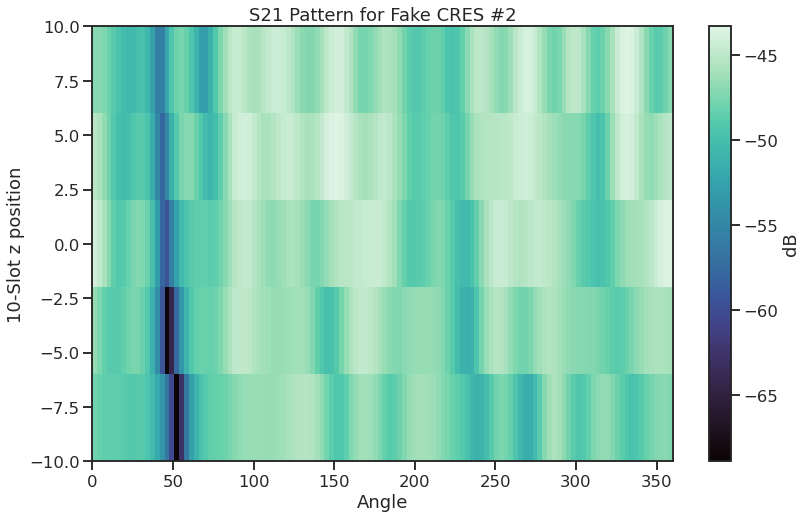

In [13]:

sns.set_theme(style='ticks', context='talk')
cmap = sns.color_palette('mako', as_cmap=True)
fig = plt.figure(figsize=(13, 8))

ax = fig.add_subplot(1,1,1)

img = ax.imshow(20 * np.log10(mag_data ), aspect='auto', cmap=cmap, extent=(0, 360, -10, 10))

cbar = fig.colorbar(img, label ='dB')

ax.set_xlabel('Angle')
ax.set_ylabel('10-Slot z position')
ax.set_title('S21 Pattern for Fake CRES #2')

name = '220110_cres2_example_s21_mag_pattern_10slot'
#plt.savefig(os.path.join(PATH, 'plots', 'moth', name))
#ax = fig.add_subplot(1,1,1, projection='3d')

#plt.plot_surface(ang_grid, z_grid, 20 * np.log10(mag_data ), cmap=cmap, edgecolor='k')


#ax.set_zlim3d(-70, -40)


# plot an example phase curve 

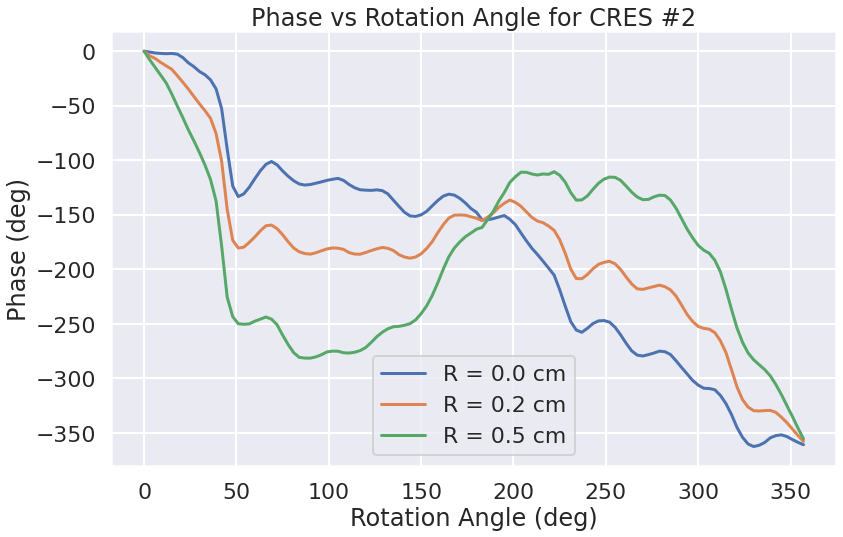

In [14]:
sns.set_theme(context='poster', style='darkgrid')
fig = plt.figure(figsize=(13, 8))

ax = fig.add_subplot(1,1,1)

phases = np.degrees(np.unwrap(np.angle(np.roll(datafile['range3cm_step1mm_z0mm']['array'][0, 0:120, 601], 0))))

ax.plot(np.arange(0, 360, 3), phases - phases[0], label=f'R = 0.0 cm')

phases = np.degrees(np.unwrap(np.angle(np.roll(datafile['range3cm_step1mm_z0mm']['array'][2, 0:120, 601], 0))))

ax.plot(np.arange(0, 360, 3), phases - phases[0], label=f'R = 0.2 cm')

phases = np.degrees(np.unwrap(np.angle(np.roll(datafile['range3cm_step1mm_z0mm']['array'][5, 0:120, 601], 0))))

ax.plot(np.arange(0, 360, 3), phases - phases[0], label=f'R = 0.5 cm')

#phases = np.degrees(np.unwrap(np.angle(np.roll(datafile['range1cm_step1mm_z0mm']['array'][, 0:120, 601], 0))))

#ax.plot(np.arange(0, 360, 3), phases - phases[0], label=f'R = 1.0 cm')

ax.set_xlabel('Rotation Angle (deg)')
ax.set_ylabel('Phase (deg)')
ax.set_title('Phase vs Rotation Angle for CRES #2')

plt.legend(loc=8)

name = '220110_phase_vs_rotation_cres2_10slot'

#plt.savefig(os.path.join(PATH, 'plots/moth', name))

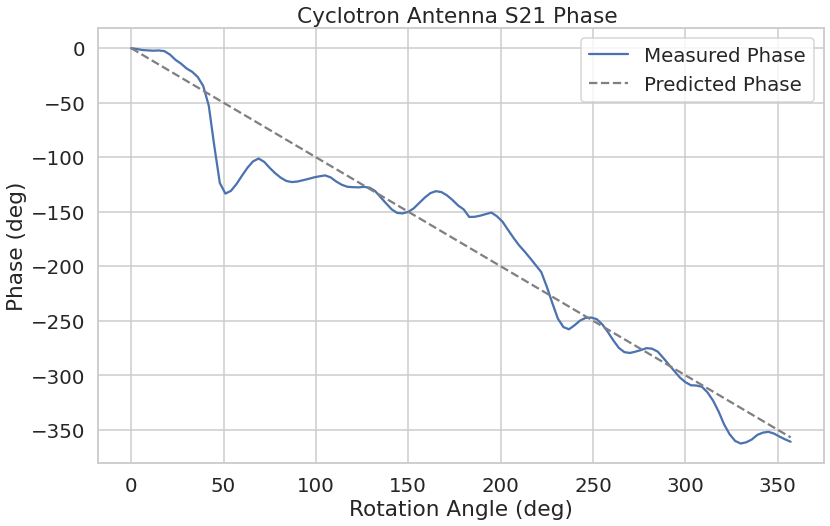

In [15]:
sns.set_theme(context='talk', style='whitegrid', font_scale=1.2)
fig = plt.figure(figsize=(13, 8))

x = np.arange(0, 360, 3)
ax = fig.add_subplot(1,1,1)

phase_total = np.zeros(x.size)
for z in [0,]:
    phase = np.degrees(np.unwrap(np.angle(np.roll(datafile[f'range3cm_step1mm_z{z}mm']['array'][0, 0:120, 601], 0))))
    ax.plot(x, phase-phase[0], label=f'Measured Phase')
    #phase_total += np.degrees(np.unwrap(np.angle(np.roll(datafile[f'range3cm_step1mm_z{z}mm']['array'][0, 0:120, 601], 0))))
phase_total /= 5

#ax.plot(x, phase_total - phase_total[0], label=f'Measured S21 Phase')
ax.plot(x, -x, color='grey', linestyle='--', label='Predicted Phase')

ax.set_xlabel('Rotation Angle (deg)')
ax.set_ylabel('Phase (deg)')
ax.set_title(r'Cyclotron Antenna S21 Phase ')

plt.legend(loc=1,)

name = '220727_phase_vs_rotation_cyclotron_emitter'

#plt.savefig(os.path.join(PATH, 'plots/analysis/antenna/cyclotron_emitter', name))

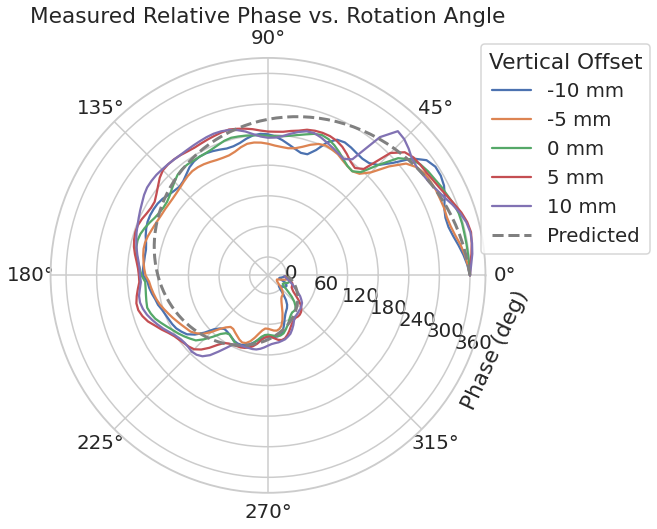

In [16]:
sns.set_theme(context='talk', style='whitegrid', font_scale=1.2)
fig = plt.figure(figsize=(12, 8))
ncopies = 1

x = np.arange(0, 360 * ncopies, 3)
ax = fig.add_subplot(1,1,1, projection='polar')


phase_total = np.zeros(x.size)
for z in [-10, -5, 0, 5, 10]:
    phase = np.degrees(np.unwrap(np.angle(np.roll(datafile[f'range3cm_step1mm_z{z}mm']['array'][0, 0:120, 601], 0))))
    #phase = np.degrees(np.unwrap(np.radians(np.tile(phase, (1, ncopies))).squeeze()))
        
    ax.plot(np.radians(x), (phase-phase[0])+360, '-', label=f'{z} mm', markersize=9)
    #phase_total += np.degrees(np.unwrap(np.angle(np.roll(datafile[f'range3cm_step1mm_z{z}mm']['array'][0, 0:120, 601], 0))))
phase_total /= 5

#ax.plot(x, phase_total - phase_total[0], label=f'Measured S21 Phase')
ax.plot(np.radians(x), -x+360, color='grey', linestyle='--', label='Predicted', lw=3)

#ax.set_xlabel('Rotation Angle (deg)')
#ax.set_ylabel('Phase (deg)')
ax.set_title(r'Measured Relative Phase vs. Rotation Angle')
ax.set_rlabel_position(-22.5)
ax.text(np.radians(-35), 420, 'Phase (deg)', rotation = 65)

ax.set_yticks(np.arange(0, 420, 60))
plt.legend(loc=(0.99, .55),ncol=1, title='Vertical Offset')
#plt.tight_layout()

name = '220919_measured_relative_phase_interpolate'
#plt.savefig(os.path.join(PATH, 'plots/analysis/antenna/cyclotron_emitter', name), dpi=256)

# plot phase curves with spatial phase removed

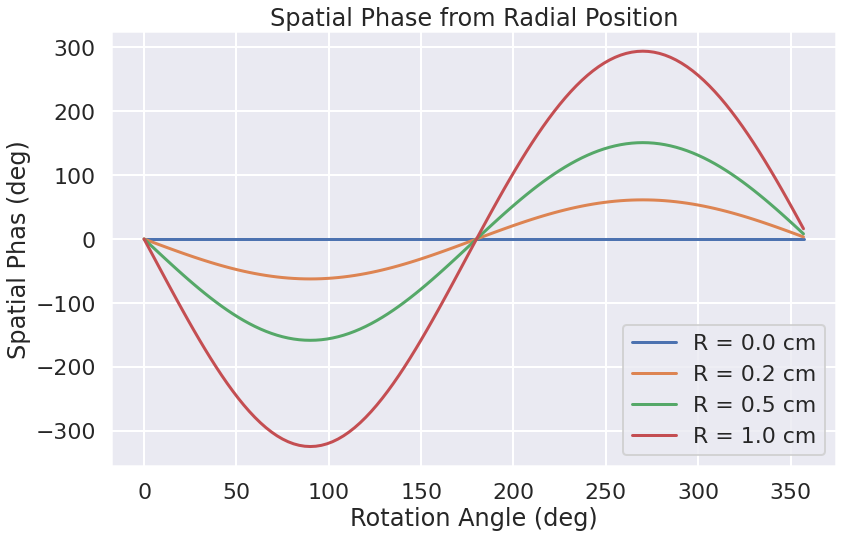

In [17]:
sns.set_theme(context='poster', style='darkgrid')
fig = plt.figure(figsize=(13, 8))

ax = fig.add_subplot(1,1,1)

ax.plot(np.arange(0, 360, 3), np.degrees(SpatialPhaseCorrection(0.0, 90)), label = 'R = 0.0 cm')
ax.plot(np.arange(0, 360, 3), np.degrees(SpatialPhaseCorrection(0.002, 90)), label = 'R = 0.2 cm')
ax.plot(np.arange(0, 360, 3), np.degrees(SpatialPhaseCorrection(0.005, 90)), label = 'R = 0.5 cm')
ax.plot(np.arange(0, 360, 3), np.degrees(SpatialPhaseCorrection(0.01, 90)), label = 'R = 1.0 cm')

ax.set_xlabel('Rotation Angle (deg)')
ax.set_ylabel('Spatial Phas (deg)')
ax.set_title('Spatial Phase from Radial Position')
plt.legend(loc=4)

name = '220110_spatial_phases_offaxis'

#plt.savefig(os.path.join(PATH, 'plots/moth', name))

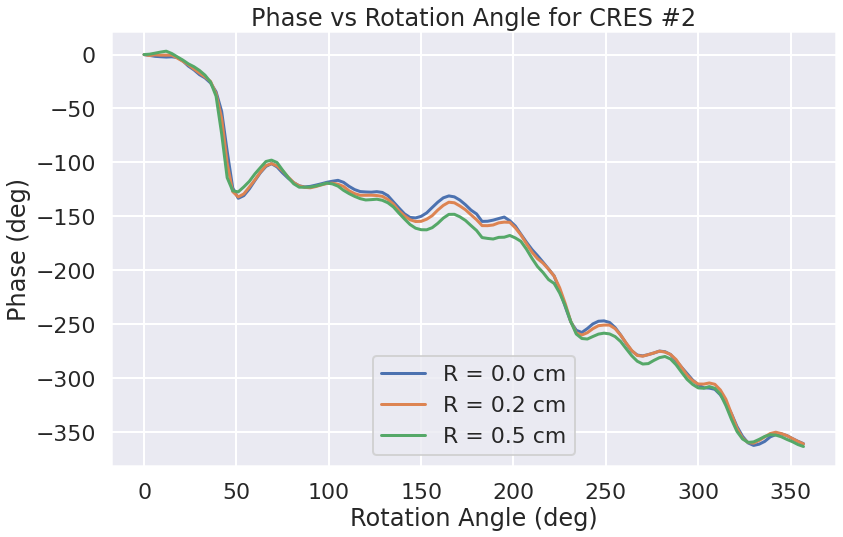

In [22]:
sns.set_theme(context='poster', style='darkgrid')
fig = plt.figure(figsize=(13, 8))

ax = fig.add_subplot(1,1,1)

phases = np.degrees(np.unwrap(np.angle(np.roll(datafile['range3cm_step1mm_z0mm']['array'][0, 0:120, 601], 0))))

ax.plot(np.arange(0, 360, 3), phases - phases[0] - np.degrees(SpatialPhaseCorrection(0.0, 90)), label=f'R = 0.0 cm')

phases = np.degrees(np.unwrap(np.angle(np.roll(datafile['range3cm_step1mm_z0mm']['array'][2, 0:120, 601], 0))))

ax.plot(np.arange(0, 360, 3), phases - phases[0] - np.degrees(SpatialPhaseCorrection(0.002, 90)), label=f'R = 0.2 cm')

phases = np.degrees(np.unwrap(np.angle(np.roll(datafile['range3cm_step1mm_z0mm']['array'][5, 0:120, 601], 0))))

ax.plot(np.arange(0, 360, 3), phases - phases[0] - np.degrees(SpatialPhaseCorrection(0.005, 90)), label=f'R = 0.5 cm')

#phases = np.degrees(np.unwrap(np.angle(np.roll(datafile['range1cm_step1mm_z0mm']['array'][, 0:120, 601], 0))))

#ax.plot(np.arange(0, 360, 3), phases - phases[0], label=f'R = 1.0 cm')

ax.set_xlabel('Rotation Angle (deg)')
ax.set_ylabel('Phase (deg)')
ax.set_title('Phase vs Rotation Angle for CRES #2')

plt.legend(loc=8)

name = '220110_phase_vs_rotation_cres2_10slot_corrected'

#plt.savefig(os.path.join(PATH, 'plots/moth', name))

# plot several magnitude curves

KeyError: "Unable to open object (object 'range1cm_step1mm_z-10mm' doesn't exist)"

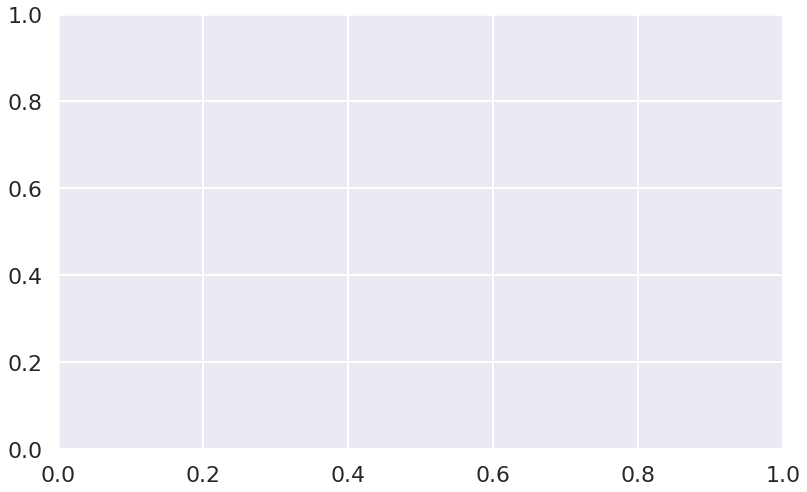

In [19]:
sns.set_theme(context='poster', style='darkgrid')
fig = plt.figure(figsize=(13, 8))

ax = fig.add_subplot(1,1,1)


mags = 20 * np.log10(abs(np.roll(datafile['range1cm_step1mm_z-10mm']['array'][0, 0:120, 601], 0)))

ax.plot(np.arange(0, 360, 3), mags, label=f'z = -1.0 cm')

mags = 20 * np.log10(abs(np.roll(datafile['range1cm_step1mm_z-5mm']['array'][0, 0:120, 601], 0)))

ax.plot(np.arange(0, 360, 3), mags, label=f'z = -0.5 cm')

mags = 20 * np.log10(abs(np.roll(datafile['range1cm_step1mm_z0mm']['array'][0, 0:120, 601], 0)))

ax.plot(np.arange(0, 360, 3), mags, label=f'z = 0.0 cm')

mags = 20 * np.log10(abs(np.roll(datafile['range1cm_step1mm_z5mm']['array'][0, 0:120, 601], 0)))

ax.plot(np.arange(0, 360, 3), mags, label=f'z = 0.5 cm')

mags = 20 * np.log10(abs(np.roll(datafile['range1cm_step1mm_z10mm']['array'][0, 0:120, 601], 0)))

ax.plot(np.arange(0, 360, 3), mags, label=f'z = 1.0 cm')

ax.set_xlabel('Rotation Angle (deg)')
ax.set_ylabel('Mag (dB)')
ax.set_title('Mag vs Rotation Angle for CRES #2')

ax.set_ylim(-70, -30)

plt.legend(loc=4)

name = '220110_mag_vs_rotation_cres2_10slot'

#plt.savefig(os.path.join(PATH, 'plots/moth', name))


# plot several magnitude curves

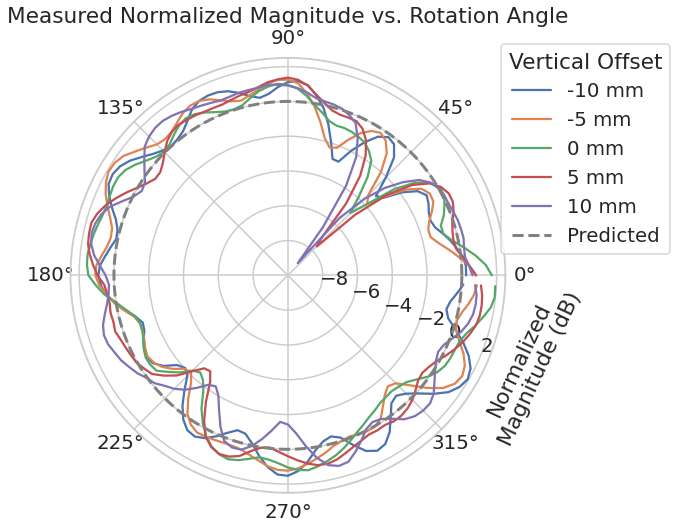

In [23]:
sns.set_theme(context='talk', style='whitegrid', font_scale=1.2)
fig = plt.figure(figsize=(12, 8))

x = np.radians(np.arange(0, 360, 3))
ax = fig.add_subplot(1,1,1, projection='polar')

mags_total = np.zeros(x.size)
markers = ['o', 's', 'd', 'v', 'x' ]

for i , z_pos in enumerate([-10, -5, 0, 5, 10]):
    mag  = 10 * np.log10(abs(np.roll(datafile[f'range3cm_step1mm_z{z_pos}mm']['array'][0, 0:120, 601], 0)))
    mag = mag - np.mean(mag)
    #mag  = abs(np.roll(datafile[f'range3cm_step1mm_z{z_pos}mm']['array'][0, 0:120, 601], 0))**2
    ax.plot(x, mag, '-', label=f"{z_pos} mm", markersize=9,)
    #mags_total += 20 * np.log10(abs(np.roll(datafile[f'range3cm_step1mm_z{z_pos}mm']['array'][0, 0:120, 601], 0)))
#mags_total /= 5

#ax.plot(x, mags_total, label="Measured S21 Magnitude")
ax.plot(np.radians(np.linspace(0, 360, 1001)), np.ones(1001) * np.mean(mag), color='grey', linestyle='--', label='Predicted', lw=3)

ax.set_title(r'Measured Normalized Magnitude vs. Rotation Angle')

#ax.text(np.pi/3, -75, 'Mag (dB)', rotation=25)
#ax.text(-np.pi/3, -40, 'Rotation Angle (deg)', rotation=0)

ax.set_ylim(-10, 2.5)
#ax.set_yticks(np.arange(-33, -18, 3))
ax.set_rlabel_position(-22.5)

ax.legend(loc=(0.99, 0.55),title='Vertical Offset')
ax.text(np.radians(-35), 7, 'Normalized\nMagnitude (dB)', rotation = 65, horizontalalignment='center')
#plt.tight_layout()

name = '221031_mag_vs_rotation_cyclotron_emitter_interpolate'

#plt.savefig(os.path.join(PATH, 'plots/analysis/antenna/cyclotron_emitter', name), dpi=256)


In [ ]:
plt.plot(10 * np.log10(abs(np.roll(datafile['range3cm_step1mm_z0mm']['array'][5, 0:120, 201], 0)) ** 2))

plt.ylim(-80, -40)

In [ ]:
os.listdir(os.path.join(LABDATAPATH, 'vna', '211119_cres2_vna_trace'))

In [ ]:
angles = np.arange(0, 360, 360 // 60)

In [ ]:
np.argwhere(angles == 12)[0, 0]

In [ ]:
np.linspace(0, 360, 121)[0:120]